In [1038]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [1039]:
df=pd.read_csv('penguins.csv')

In [1040]:
df.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [1041]:
df.shape

(344, 5)

In [1042]:
df.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

In [1043]:
df=df.dropna()

In [1044]:
df.isnull().sum()

CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64

In [1045]:
features=['CulmenLength','CulmenDepth','FlipperLength','BodyMass']

In [1046]:
target=['Species']

In [1047]:
df[target].value_counts()

Species
0          151
1          123
2           68
Name: count, dtype: int64

In [1048]:
X=df[features]
y=df[target]

In [1049]:
X.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [1050]:
%%javascript
IPython.OutputArea.prototype._should_scroll=false

<IPython.core.display.Javascript object>

In [1051]:
######  EDA  #########

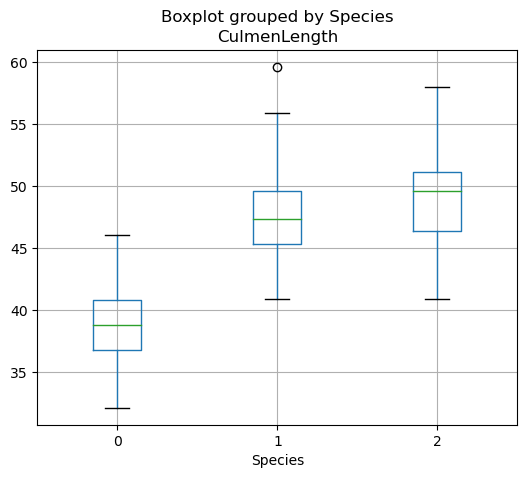

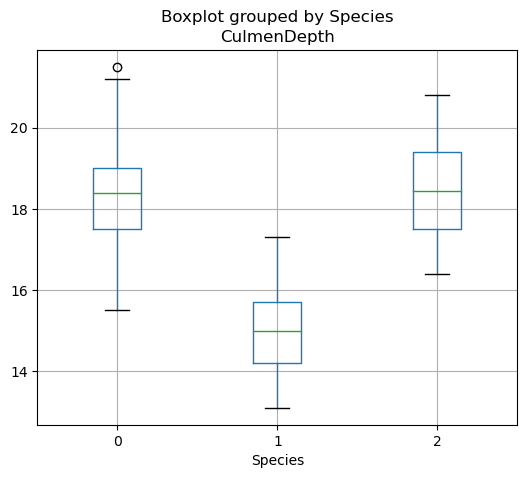

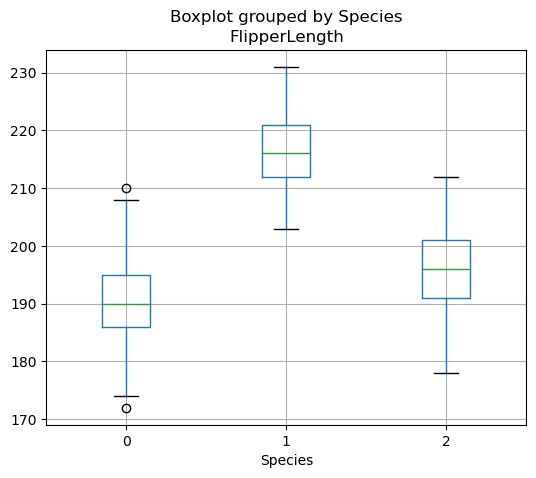

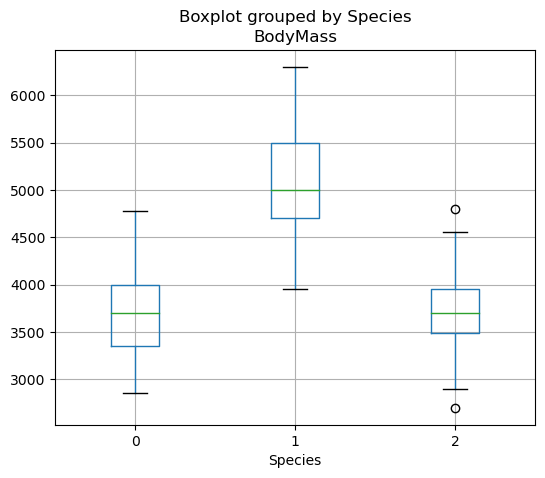

In [1052]:
for col in features:
    df.boxplot(column=col,by='Species',figsize=(6,5))
    plt.title(col)
    plt.show()
    

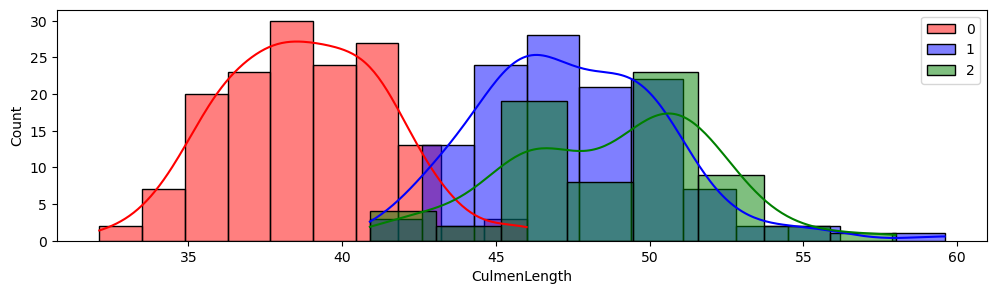

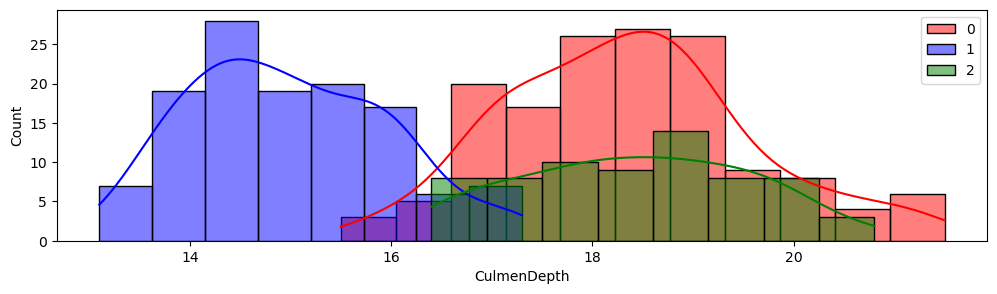

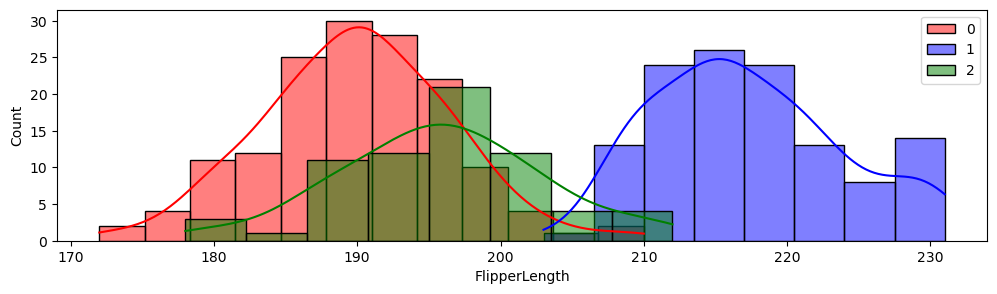

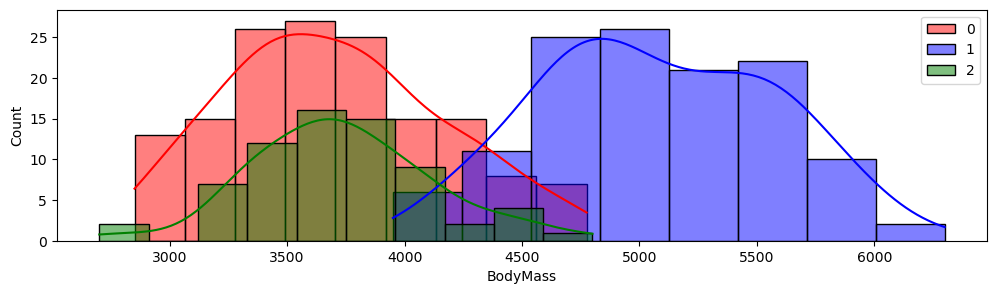

In [1053]:
for col in features:
    plt.figure(figsize=(12,3))
    sns.histplot(df.loc[df['Species']==0,col],kde=True,color='red',label='0')
    sns.histplot(df.loc[df['Species']==1,col],kde=True,color='blue',label='1')
    sns.histplot(df.loc[df['Species']==2,col],kde=True,color='green',label='2')
    plt.legend(loc='upper right')
    plt.show()

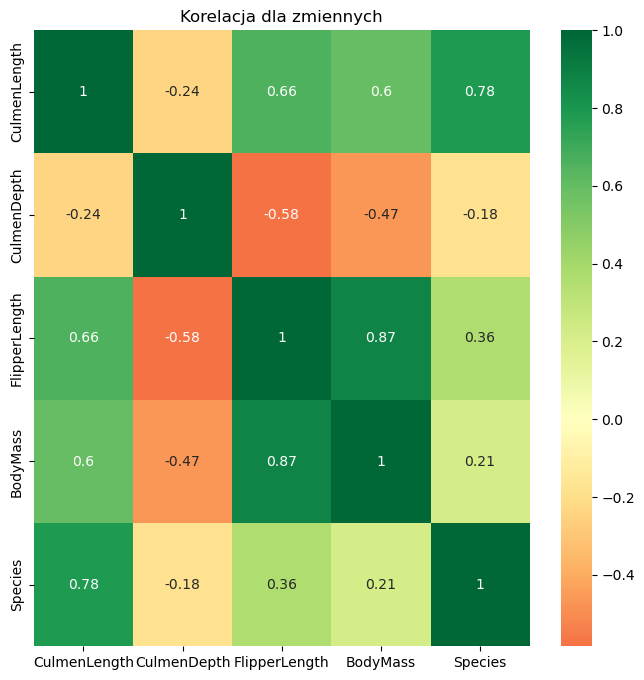

In [1054]:
plt.figure(figsize=(8,8))
ax=sns.heatmap(df.corr(),
              xticklabels=df.corr().columns,
              yticklabels=df.corr().columns,
              center=0,
              annot=True,
              cmap="RdYlGn")
plt.title('Korelacja dla zmiennych')
plt.show()
    


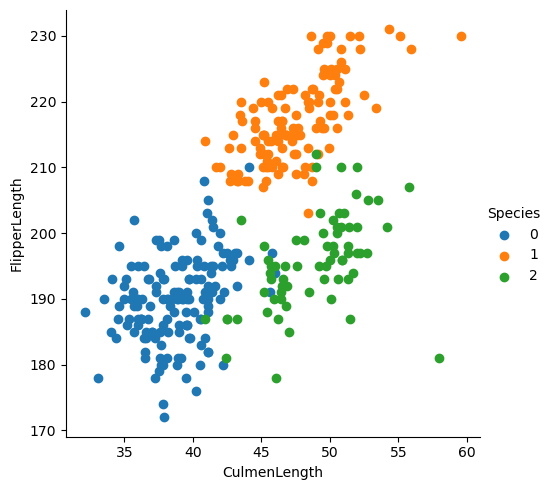

In [1055]:
sns.FacetGrid(df,hue='Species',height=5).map(plt.scatter,'CulmenLength','FlipperLength').add_legend()

In [1056]:
# Podział danych na testowe i treningowe

In [1057]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [1058]:
# Skalowanie danych

In [1059]:
from sklearn.preprocessing import StandardScaler

In [1060]:
scaled=StandardScaler()
X_train_scaled=scaled.fit_transform(X_train)
X_test_scaled=scaled.transform(X_test)

In [1061]:
######  Metryki dla modeli #####


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score'])


def show_stats(model_name,model_predictions):
    cm=confusion_matrix(y_test,model_predictions)
    ax=sns.heatmap(cm,annot=True,fmt='.0f')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()
    
    print(model_name.upper(),'\n\n')
    print(classification_report(y_test, model_predictions))
    
    global metrics_dataframe
    f1_metric =f1_score(y_test,model_predictions,average='weighted')
    metrics_dataframe=metrics_dataframe._append({'Model':model_name,'F1_score':f1_metric},ignore_index=True)
    
    display( metrics_dataframe.sort_values(by='F1_score',ascending=False))

In [1062]:
#  Logistic Regression (parametric model)

In [1063]:
from sklearn.linear_model import LogisticRegression

In [1064]:
# lr=LogisticRegression().fit(X_train_scaled,y_train)
# predictions_lr=lr.predict(X_test_scaled)

In [1065]:
from sklearn.model_selection import GridSearchCV

In [1066]:
lr_params={'C':np.arange(0.1,10,0.1),'penalty':['l1', 'l2', 'elasticnet', None]}
lr=LogisticRegression( solver='liblinear')
lr_grid=GridSearchCV(lr,lr_params,scoring='f1',cv=10)
lr_grid.fit(X_train_scaled,y_train)
print("Najlepsze parametry to: ",lr_grid.best_params_)
lr_grid_best=lr_grid.best_estimator_
predictions_lr=lr_grid_best.predict(X_test_scaled)


Najlepsze parametry to:  {'C': 0.1, 'penalty': 'l1'}


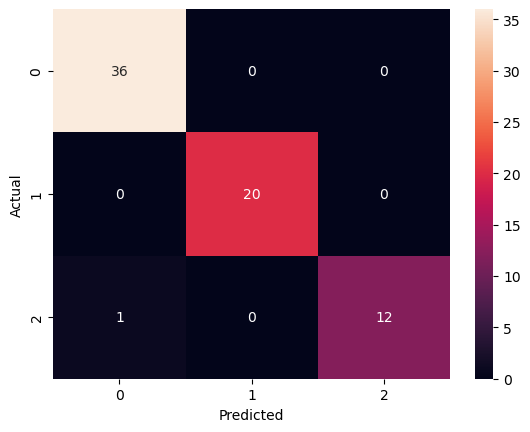

LOGISTIC_REGRESSION 


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       1.00      1.00      1.00        20
           2       1.00      0.92      0.96        13

    accuracy                           0.99        69
   macro avg       0.99      0.97      0.98        69
weighted avg       0.99      0.99      0.99        69



,Model,F1_score
0,logistic_regression,0.985317


In [1067]:
show_stats('logistic_regression',predictions_lr)

In [1068]:
# K Nearest Neighbours

In [1069]:
from sklearn.neighbors import KNeighborsClassifier

In [1070]:
knn=KNeighborsClassifier()
knn_params={'n_neighbors':[5,7,9,11,13,15],
           'weights':['uniform', 'distance'],
            'algorithm':['ball_tree','kd_tree','brute','auto'],
            'leaf_size':[1,5,10,15,20],
            'p':[1,2],
            'metric':['minkowski','euclidean','manhattan']}

knn_grid=GridSearchCV(knn,knn_params,scoring='f1',cv=10)
knn_grid.fit(X_train_scaled,y_train)
print("Najlepsze parametry to: ",knn_grid.best_params_)

Najlepsze parametry to:  {'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [1071]:
knn_grid_best=knn_grid.best_estimator_
predictions_knn=knn_grid_best.predict(X_test_scaled)

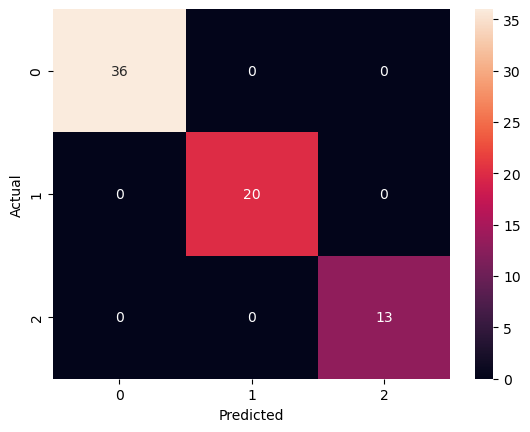

KNN 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        13

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



,Model,F1_score
1,knn,1.000000
0,logistic_regression,0.985317


In [1072]:
show_stats('knn',predictions_knn)

In [1073]:
# Decision Tree 

In [1074]:
from sklearn.tree import DecisionTreeClassifier


In [1075]:
dt=DecisionTreeClassifier()
params_dt={'max_depth':[10,30,50,70,90,100],
          'criterion':['gini','entropy'],
          'max_features':['log2', 'sqrt',None],
           'min_samples_split':[2,4,6]
          }

grid_dt=GridSearchCV(dt,params_dt,cv=10,scoring='f1')
grid_dt.fit(X_train,y_train)
print("Najlepsze parametry: ",grid_dt.best_params_)


Najlepsze parametry:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2}


In [1076]:
grid_dt_best=grid_dt.best_estimator_
predictions_dt=grid_dt_best.predict(X_test)

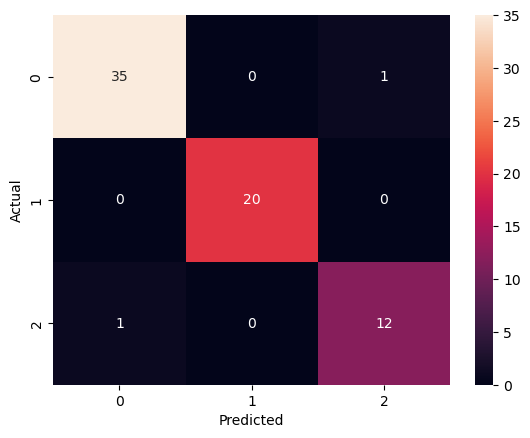

DECISION TREE 


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       1.00      1.00      1.00        20
           2       0.92      0.92      0.92        13

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69



,Model,F1_score
1,knn,1.000000
0,logistic_regression,0.985317
2,decision tree,0.971014


In [1077]:
show_stats("decision tree",predictions_dt)

In [1078]:
#### SVC ####

In [1079]:
from sklearn.svm import SVC

In [1080]:
svc=SVC()
params_svc={'kernel':['linear', 'poly', 'rbf'],
           'C':[0.1,1,10,100,1000],
           'gamma':[0.0001,0.001,0.01,0.1,1]}

In [1081]:
grid_svc=GridSearchCV(svc,params_svc,cv=10,scoring='f1')
grid_svc.fit(X_train_scaled,y_train)
print("Najlepsze parametry: ",grid_svc.best_params_)

Najlepsze parametry:  {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


In [1082]:
grid_svc_best=grid_svc.best_estimator_

In [1083]:
predictions_svc=grid_svc_best.predict(X_test_scaled)

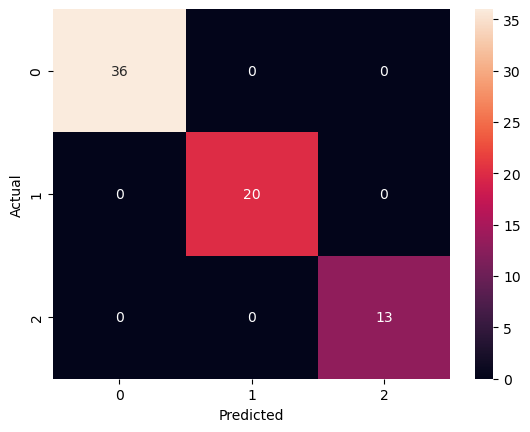

SVC 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        13

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



,Model,F1_score
1,knn,1.000000
3,svc,1.000000
0,logistic_regression,0.985317
2,decision tree,0.971014


In [1084]:
show_stats('svc',predictions_svc)


In [1085]:
####### Random Forest #############

In [1086]:
from sklearn.ensemble import RandomForestClassifier

In [1087]:
rfc=RandomForestClassifier(n_estimators=1000,n_jobs=-1)

In [1088]:
params_rfc={
           'max_depth':np.arange(1,5,1),
           'min_samples_leaf':[1,2,3]}

In [1089]:
grid_rfc=GridSearchCV(rfc,params_rfc,cv=10,scoring='f1')
grid_rfc.fit(X_train,y_train)
print('Najlepsze parametry :',grid_rfc.best_params_)

Najlepsze parametry : {'max_depth': 1, 'min_samples_leaf': 1}


In [1090]:
grid_rfc_best=grid_rfc.best_estimator_

In [1091]:
predictions_rfc=grid_rfc_best.predict(X_test)

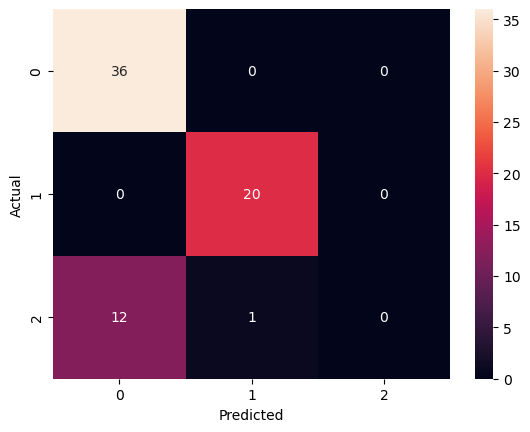

RANDOM FOREST CLASSIFIER 


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        36
           1       0.95      1.00      0.98        20
           2       0.00      0.00      0.00        13

    accuracy                           0.81        69
   macro avg       0.57      0.67      0.61        69
weighted avg       0.67      0.81      0.73        69



,Model,F1_score
1,knn,1.000000
3,svc,1.000000
0,logistic_regression,0.985317
2,decision tree,0.971014
4,Random Forest Classifier,0.729990


In [1092]:
show_stats('Random Forest Classifier',predictions_rfc)

In [1093]:
#### ADA Boost ####

In [1094]:
from sklearn.ensemble import AdaBoostClassifier

In [1095]:
ab=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))
params_ab={'n_estimators':[10,20,50,100,1000],
          'algorithm':['SAMME', 'SAMME.R']}
grid_ab=GridSearchCV(ab,params_ab,cv=10,scoring='f1')
grid_ab.fit(X_train,y_train)
print("Najlepsze parametry:" ,grid_ab.best_params_)

Najlepsze parametry: {'algorithm': 'SAMME', 'n_estimators': 10}


In [1096]:
grid_ab_best=grid_ab.best_estimator_

In [1097]:
predictions_ab=grid_ab_best.predict(X_test)

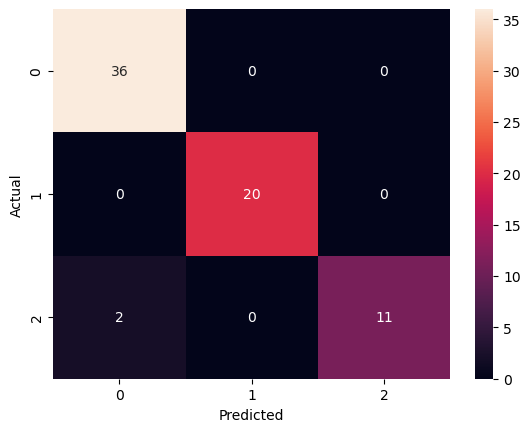

ADABOOST 


              precision    recall  f1-score   support

           0       0.95      1.00      0.97        36
           1       1.00      1.00      1.00        20
           2       1.00      0.85      0.92        13

    accuracy                           0.97        69
   macro avg       0.98      0.95      0.96        69
weighted avg       0.97      0.97      0.97        69



,Model,F1_score
1,knn,1.000000
3,svc,1.000000
0,logistic_regression,0.985317
2,decision tree,0.971014
5,AdaBoost,0.970198
4,Random Forest Classifier,0.729990


In [1098]:
show_stats("AdaBoost",predictions_ab)